<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from mantisshrimp.all import *
from enum import Enum

In [2]:
source = Path('/home/lgvaz/.data/PennFudanPed/')

In [3]:
class PersonImageParser(ImageParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        # Get size
        sz = self.lines.filter(lambda o: o.startswith('Image size (X x Y x C)'))[0]
        sz = re.search(r'\d{3,4}\sx\s\d{3,4}\sx\s3', sz).group()
        self.sz = lmap(int, sz.split('x'))
        
    def iid(self, o): return self.i
    def file_path(self, o):
        fp = self.lines.filter(lambda o: o.startswith('Image filename'))[0]
        fp = re.findall(r'"(.*)"', fp)[0]
        return self.source.parent/fp
    
    def width(self, o):  return self.sz[0]
    def height(self, o): return self.sz[1]

In [4]:
class PersonAnnotationParser(AnnotationParser):
    def prepare(self, o):
        self.i = getattr(self, 'i', 0) + 1
        self.lines = L(o.read().split('\n'))
        ln = self.lines.filter(lambda o: o.startswith('Objects with ground truth'))[0]
        self.n = int(re.findall('\d+', ln)[0])
        
    def iid(self, o): return self.i
    def oid(self, o): return [1]*self.n
    def iscrowd(self, o): return [0]*self.n
        
    def bbox(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Bounding box'))
        bboxes = []
        for bbox in lines:
            bbox = re.findall(r'(\d+,\s\d+)', bbox)
            bbox = lmap(lambda o: lmap(int, o.split(',')), bbox)
            bbox = np.array(bbox).flat
            bboxes.append(BBox.from_xyxy(*bbox))
        return bboxes
    
    def seg(self, o):
        lines = self.lines.filter(lambda o: o.startswith('Pixel mask for object'))
        line = lines[0] # All lines contain the same mask
        fp = self.source.parent/re.findall(r'"(.+)"', line.split(':')[-1])[0]
        return MaskFile(fp)

In [5]:
class PersonParser(DataParser):
    def get_img_parser(self, o, source): return PersonImageParser(o, source)
    def get_annot_parser(self, o, source): return PersonAnnotationParser(o, source)

In [6]:
fns = get_files(source/'Annotation', extensions='.txt')

In [7]:
parser = PersonParser(fns, source)
train,valid = parser.parse()


Removed 0 images that don't have annotations


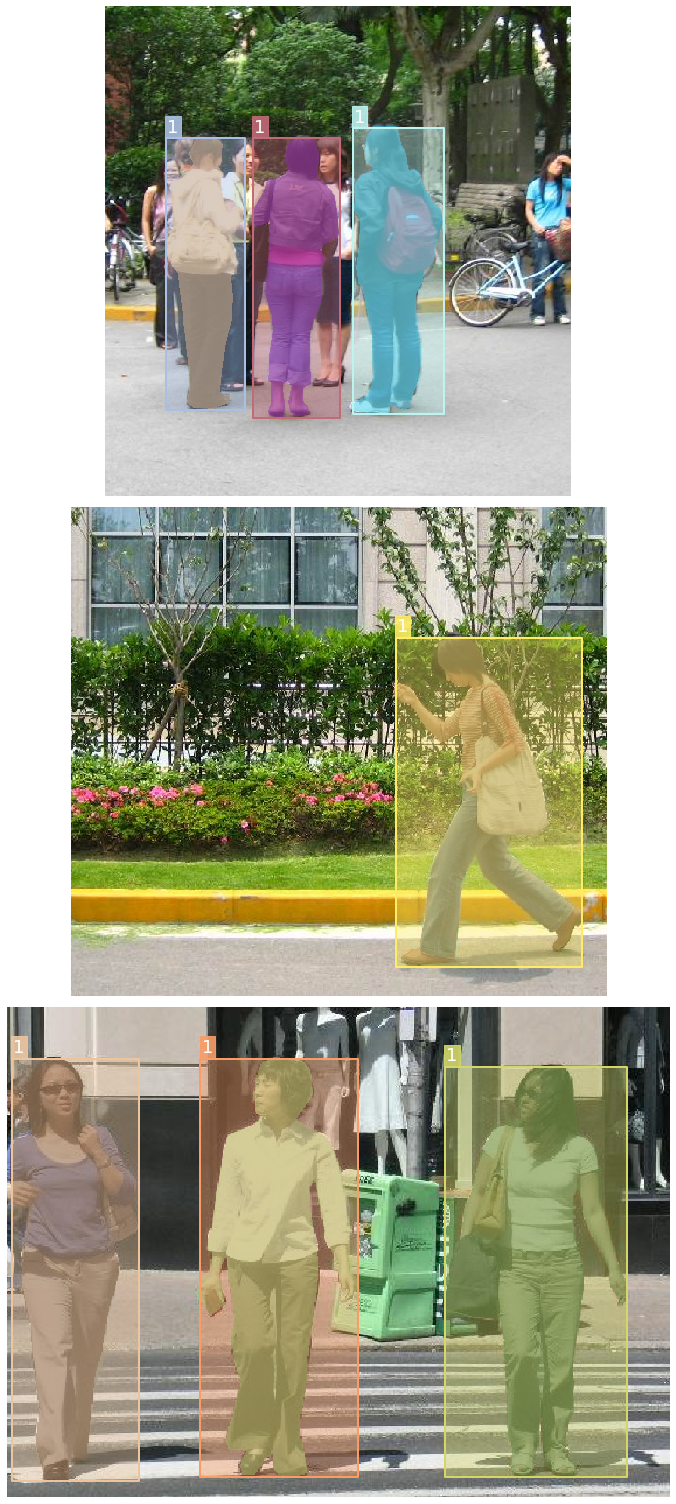

In [8]:
grid(partial(show_record, bbox=True), train[42:45])

In [9]:
tfms = AlbumentationTransformer([A.HorizontalFlip(p=.5)])

In [12]:
ds_train = Dataset(train, tfms)
ds_valid = Dataset(valid)

In [11]:
ds_valid[0]

(tensor([[[0.2902, 0.2980, 0.3059,  ..., 0.6314, 0.6392, 0.6392],
          [0.2784, 0.2824, 0.2863,  ..., 0.6431, 0.6471, 0.6471],
          [0.2863, 0.2863, 0.2902,  ..., 0.6471, 0.6471, 0.6471],
          ...,
          [0.5059, 0.4941, 0.4902,  ..., 0.5020, 0.5216, 0.5216],
          [0.4706, 0.4627, 0.4627,  ..., 0.5137, 0.5216, 0.5216],
          [0.4902, 0.4824, 0.4902,  ..., 0.5216, 0.5255, 0.5255]],
 
         [[0.3020, 0.3098, 0.3176,  ..., 0.5922, 0.5922, 0.5922],
          [0.2902, 0.2941, 0.2980,  ..., 0.6039, 0.6000, 0.6000],
          [0.2980, 0.2980, 0.3020,  ..., 0.6078, 0.6000, 0.6000],
          ...,
          [0.5098, 0.4980, 0.4941,  ..., 0.5020, 0.5216, 0.5216],
          [0.4745, 0.4667, 0.4667,  ..., 0.5137, 0.5216, 0.5216],
          [0.4941, 0.4863, 0.4941,  ..., 0.5216, 0.5255, 0.5255]],
 
         [[0.2353, 0.2431, 0.2510,  ..., 0.5882, 0.6000, 0.6000],
          [0.2235, 0.2275, 0.2314,  ..., 0.6000, 0.6078, 0.6078],
          [0.2314, 0.2314, 0.2353,  ...,

In [12]:
ds = Dataset(records, tfms)
dl = RCNNDataloader(ds, batch_size=2)

In [16]:
model = MaskRCNNModel(2)

In [17]:
trainer = pl.Trainer(max_epochs=2, gpus=1)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [18]:
trainer.fit(model, dl)

INFO:lightning:
    | Name                                       | Type                     | Params
------------------------------------------------------------------------------------
0   | m                                          | MaskRCNN                 | 43 M  
1   | m.transform                                | GeneralizedRCNNTransform | 0     
2   | m.backbone                                 | BackboneWithFPN          | 26 M  
3   | m.backbone.body                            | IntermediateLayerGetter  | 23 M  
4   | m.backbone.body.conv1                      | Conv2d                   | 9 K   
5   | m.backbone.body.bn1                        | FrozenBatchNorm2d        | 0     
6   | m.backbone.body.relu                       | ReLU                     | 0     
7   | m.backbone.body.maxpool                    | MaxPool2d                | 0     
8   | m.backbone.body.layer1                     | Sequential               | 212 K 
9   | m.backbone.body.layer1.0                   

/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/home/lgvaz/anaconda3/envs/light/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


1

In [33]:
model.freeze()

In [34]:
record = records[0]

In [37]:
im = open_img(record.iinfo.fp)

In [45]:
res = model([im2tensor(im).cuda()])[0]

In [99]:
r2 = record.new(annot=dict(
    bboxes=[BBox.from_xyxy(*o) for o in res['boxes']],
    segs=Mask((res['masks']>.5).long().squeeze().cpu().numpy()),
))

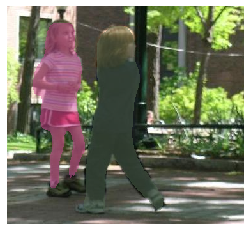

In [100]:
show_record(r2, bbox=False)